In [40]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.validation import check_X_y

def conn_index_score(X, labels, n_neighbors=1):
    """
    Compute the CONN (Connectivity) index for evaluating clustering quality.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Feature matrix.

    labels : array-like of shape (n_samples,)
        Cluster labels for each sample.

    n_neighbors : int, default=1
        Number of nearest neighbors to consider (commonly 1).

    Returns
    -------
    conn_score : float
        The CONN index score, ranging from 0 to 1. Higher is better.
    """
    X, labels = check_X_y(X, labels)
    n_samples = X.shape[0]

    if n_neighbors >= n_samples:
        raise ValueError("n_neighbors must be less than the number of samples.")

    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X)
    _, indices = nbrs.kneighbors(X)

    neighbor_indices = indices[:, 1:]  # Exclude self-neighbor

    match_count = 0
    for i in range(n_samples):
        for j in neighbor_indices[i]:
            if labels[i] == labels[j]:
                match_count += 1

    conn_score = match_count / (n_samples * n_neighbors)
    return conn_score


In [5]:
import numpy as np

def generate_ring_dataset(
    inner_radius_1, outer_radius_1,
    inner_radius_2, outer_radius_2,
    n_samples_1, n_samples_2,
    center=(0.5, 0.5), random_state=None
):
    """
    Generate a 2D dataset with two classes: ring within a ring.

    Parameters:
    - inner_radius_1, outer_radius_1: float
        Inner and outer radius for class 1 (label 0).
    - inner_radius_2, outer_radius_2: float
        Inner and outer radius for class 2 (label 1).
    - n_samples_1, n_samples_2: int
        Number of samples to generate for each class.
    - center: tuple of float
        Center of the rings (default is (0.5, 0.5)).
    - random_state: int or None
        Seed for reproducibility.

    Returns:
    - X: np.ndarray, shape (n_samples_1 + n_samples_2, 2)
        2D coordinates of the samples.
    - y: np.ndarray, shape (n_samples_1 + n_samples_2,)
        Labels (0 or 1).
    """
    rng = np.random.default_rng(random_state)

    def generate_ring(inner_r, outer_r, n):
        if not (0 <= inner_r < outer_r <= 1.0):
            raise ValueError(f"Invalid ring parameters: 0 < {inner_r=} < {outer_r=} <= 1.0 required.")
        theta = rng.uniform(0, 2 * np.pi, n)
        r = np.sqrt(rng.uniform(inner_r**2, outer_r**2, n))  # Uniform area density
        x = center[0] + r * np.cos(theta)
        y = center[1] + r * np.sin(theta)
        return np.stack((x, y), axis=1)

    X1 = generate_ring(inner_radius_1, outer_radius_1, n_samples_1)
    X2 = generate_ring(inner_radius_2, outer_radius_2, n_samples_2)

    y1 = np.zeros(n_samples_1, dtype=int)
    y2 = np.ones(n_samples_2, dtype=int)

    X = np.vstack((X1, X2))
    y = np.concatenate((y1, y2))

    return X, y


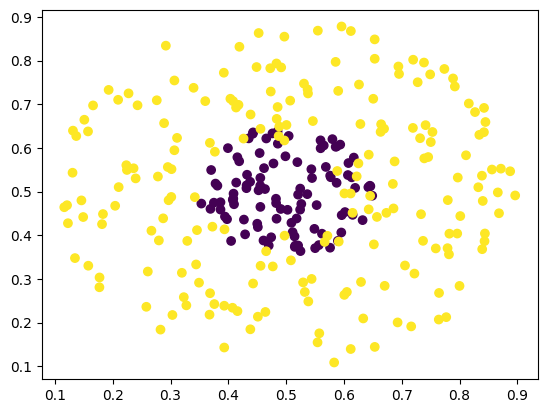

In [8]:
import matplotlib.pyplot as plt

X, y = generate_ring_dataset(0.00, 0.15, 0.1, 0.4, 100, 200)

plt.figure()
plt.scatter(X[:,0], X[:, 1], c=y)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.validation import check_X_y
from tqdm import tqdm


def analyze_ring_separation_sweep(
    generate_ring_dataset,
    width_values,
    gap_range,
    n_samples_per_class=300,
    n_seeds=10,
    plot_every_n=5,
    random_state=None,
    figsize_per_plot=(3, 3),
    conn_k=1
):
    rng = np.random.default_rng(random_state)
    gap_values = []
    sil_scores = []
    db_scores = []
    ch_scores = []
    conn_scores = []

    print("Sweeping clustering metrics...")
    for gap in tqdm(gap_range):
        sil_vals, db_vals, ch_vals, conn_vals = [], [], [], []

        for width1 in width_values:
            for width2 in width_values:
                inner_1 = 0.1
                outer_1 = inner_1 + width1
                inner_2 = outer_1 + gap
                outer_2 = inner_2 + width2

                if outer_2 > 1.0 or inner_2 <= 0 or inner_2 >= outer_2:
                    continue

                for _ in range(n_seeds):
                    seed = rng.integers(0, 1_000_000)
                    try:
                        X, y = generate_ring_dataset(
                            inner_radius_1=inner_1,
                            outer_radius_1=outer_1,
                            inner_radius_2=inner_2,
                            outer_radius_2=outer_2,
                            n_samples_1=n_samples_per_class,
                            n_samples_2=n_samples_per_class,
                            random_state=seed
                        )
                        sil_vals.append(silhouette_score(X, y))
                        db_vals.append(davies_bouldin_score(X, y))
                        ch_vals.append(calinski_harabasz_score(X, y))
                        conn_vals.append(conn_index_score(X, y, n_neighbors=conn_k))
                    except ValueError:
                        continue

        if sil_vals:
            gap_values.append(gap)
            sil_scores.append(np.mean(sil_vals))
            db_scores.append(np.mean(db_vals))
            ch_scores.append(np.mean(ch_vals))
            conn_scores.append(np.mean(conn_vals))

    gap_values = np.array(gap_values)
    sil_scores = np.array(sil_scores)
    db_scores = np.array(db_scores)
    ch_scores = np.array(ch_scores)
    conn_scores = np.array(conn_scores)

    # === Plot all 4 metrics ===
    perfect_sep = 0.0
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))

    axs[0].plot(gap_values, sil_scores, marker='o')
    axs[0].axvline(perfect_sep, color='gray', linestyle='--', label='Perfect separation')
    axs[0].set_title("Silhouette Score")
    axs[0].set_xlabel("Ring Gap")
    axs[0].set_ylabel("Score")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(gap_values, db_scores, marker='o', color='orange')
    axs[1].axvline(perfect_sep, color='gray', linestyle='--')
    axs[1].set_title("Davies-Bouldin Index")
    axs[1].set_xlabel("Ring Gap")
    axs[1].set_ylabel("Score")
    axs[1].grid(True)

    axs[2].plot(gap_values, ch_scores, marker='o', color='green')
    axs[2].axvline(perfect_sep, color='gray', linestyle='--')
    axs[2].set_title("Calinski-Harabasz Index")
    axs[2].set_xlabel("Ring Gap")
    axs[2].set_ylabel("Score")
    axs[2].grid(True)

    axs[3].plot(gap_values, conn_scores, marker='o', color='purple')
    axs[3].axvline(perfect_sep, color='gray', linestyle='--')
    axs[3].set_title(f"CONN Index (k={conn_k})")
    axs[3].set_xlabel("Ring Gap")
    axs[3].set_ylabel("Score")
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()

    # === Plot representative ring examples ===
    print("Plotting representative ring examples...")
    selected_gaps = gap_range[::plot_every_n]
    num_plots = len(selected_gaps)
    fig, axes = plt.subplots(
        1, num_plots,
        figsize=(figsize_per_plot[0] * num_plots, figsize_per_plot[1]),
        sharex=True, sharey=True
    )
    if num_plots == 1:
        axes = [axes]

    for ax, gap in zip(axes, selected_gaps):
        success = False
        attempts = 0
        while not success and attempts < 20:
            width1 = rng.choice(width_values)
            width2 = rng.choice(width_values)
            inner_1 = 0.1
            outer_1 = inner_1 + width1
            inner_2 = outer_1 + gap
            outer_2 = inner_2 + width2

            if outer_2 > 1.0 or inner_2 <= 0 or inner_2 >= outer_2:
                attempts += 1
                continue

            try:
                X, y = generate_ring_dataset(
                    inner_radius_1=inner_1,
                    outer_radius_1=outer_1,
                    inner_radius_2=inner_2,
                    outer_radius_2=outer_2,
                    n_samples_1=n_samples_per_class,
                    n_samples_2=n_samples_per_class,
                    random_state=rng.integers(0, 1_000_000)
                )
                score = silhouette_score(X, y)
                success = True
            except ValueError:
                attempts += 1
            except Exception:
                attempts += 1

        if success:
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=10, alpha=0.7)
            ax.set_title(f"gap = {gap:.3f}\nscore = {score:.3f}")
            ax.set_aspect('equal')
            ax.axis('off')
        else:
            ax.set_title(f"gap = {gap:.3f}\n[failed]")
            ax.axis('off')

    plt.tight_layout()
    plt.show()


Sweeping clustering metrics...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.06it/s]


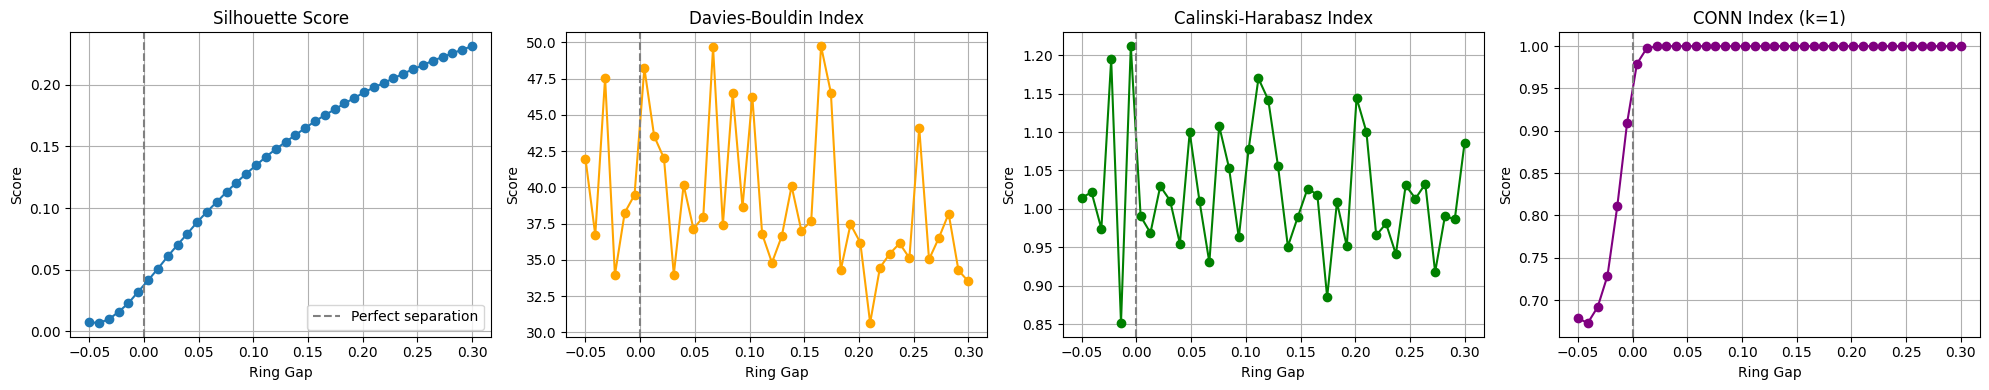

Plotting representative ring examples...


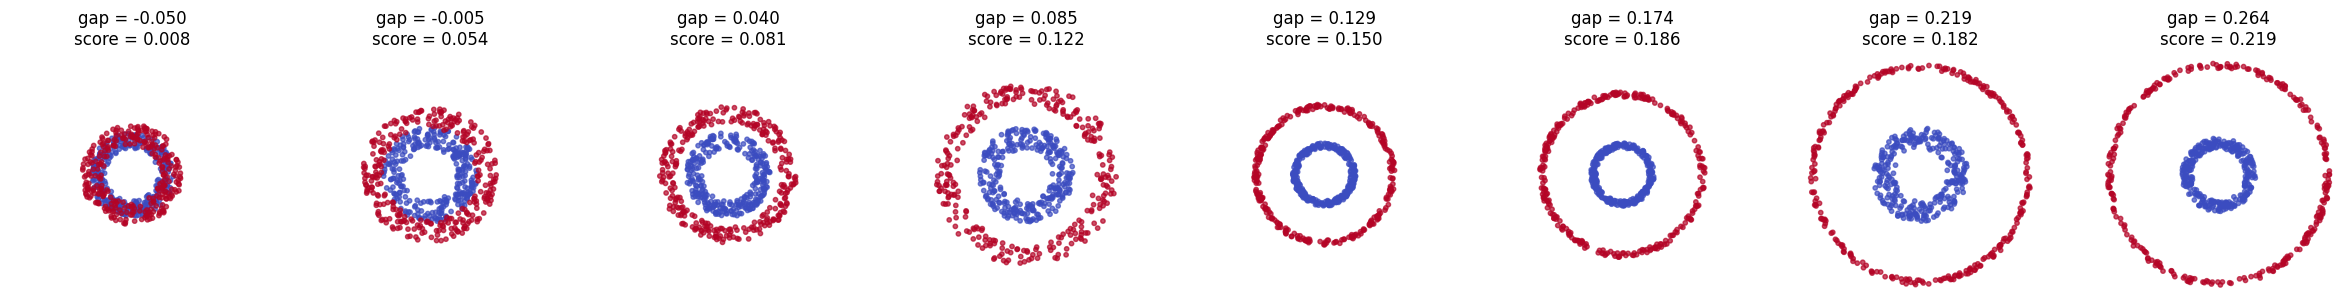

In [42]:
gap_range = np.linspace(-0.05, 0.3, 40)
width_values = [0.02, 0.04, 0.06, 0.08]

analyze_ring_separation_sweep(
    generate_ring_dataset=generate_ring_dataset,
    width_values=width_values,
    gap_range=gap_range,
    n_samples_per_class=300,
    n_seeds=10,
    plot_every_n=5,
    random_state=42
)


In [16]:
import numpy as np

def generate_circle_dataset(
    radius,
    center_distance,
    n_samples_1,
    n_samples_2,
    random_state=None
):
    """
    Generate a 2-class dataset of uniform circular blobs.

    Parameters:
    - radius: float
        Radius of both circular classes (must be > 0).
    - center_distance: float
        Horizontal distance between the two circle centers.
    - n_samples_1, n_samples_2: int
        Number of samples in each class.
    - random_state: int or None
        For reproducibility.

    Returns:
    - X: np.ndarray of shape (n_samples_1 + n_samples_2, 2)
        The 2D points.
    - y: np.ndarray of shape (n_samples_1 + n_samples_2,)
        Class labels (0 or 1).
    """
    if radius <= 0:
        raise ValueError("Radius must be greater than 0.")

    # Compute circle centers based on horizontal offset (centered around 0.5)
    cx1 = 0.5 - center_distance / 2
    cx2 = 0.5 + center_distance / 2
    cy = 0.5

    # Ensure both circles stay within [0.0, 1.0]^2
    if not (radius <= cx1 <= 1 - radius and radius <= cx2 <= 1 - radius):
        raise ValueError("Circles extend beyond horizontal bounds.")
    if not (radius <= cy <= 1 - radius):
        raise ValueError("Circles extend beyond vertical bounds.")

    rng = np.random.default_rng(random_state)

    def sample_circle(n, center_x, center_y):
        theta = rng.uniform(0, 2 * np.pi, n)
        r = np.sqrt(rng.uniform(0, radius ** 2, n))
        x = center_x + r * np.cos(theta)
        y = center_y + r * np.sin(theta)
        return np.stack((x, y), axis=1)

    X1 = sample_circle(n_samples_1, cx1, cy)
    X2 = sample_circle(n_samples_2, cx2, cy)
    y1 = np.zeros(n_samples_1, dtype=int)
    y2 = np.ones(n_samples_2, dtype=int)

    X = np.vstack((X1, X2))
    y = np.concatenate((y1, y2))

    return X, y


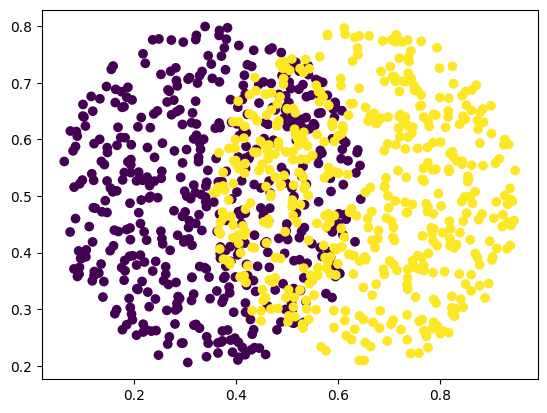

In [22]:
import matplotlib.pyplot as plt

X, y = generate_circle_dataset(
    radius=0.3,
    center_distance=0.3,
    n_samples_1=500,
    n_samples_2=500,
    random_state=42
)

plt.figure()
plt.scatter(X[:,0], X[:, 1], c=y)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from tqdm import tqdm

def analyze_circle_separation_sweep(
    generate_circle_dataset,
    radius,
    distance_range,
    n_samples_per_class=300,
    n_seeds=10,
    plot_every_n=5,
    random_state=None,
    figsize_per_plot=(3, 3),
    conn_k=1
):
    rng = np.random.default_rng(random_state)
    distances = []
    sil_scores = []
    db_scores = []
    ch_scores = []
    conn_scores = []

    print("Sweeping clustering metrics...")
    for dist in tqdm(distance_range):
        if dist / 2 + radius > 0.5:
            continue  # Circles would extend beyond unit square

        sil_vals, db_vals, ch_vals, conn_vals = [], [], [], []

        for _ in range(n_seeds):
            try:
                X, y = generate_circle_dataset(
                    radius=radius,
                    center_distance=dist,
                    n_samples_1=n_samples_per_class,
                    n_samples_2=n_samples_per_class,
                    random_state=rng.integers(0, 1_000_000)
                )
                sil_vals.append(silhouette_score(X, y))
                db_vals.append(davies_bouldin_score(X, y))
                ch_vals.append(calinski_harabasz_score(X, y))
                conn_vals.append(conn_index_score(X, y, n_neighbors=conn_k))
            except ValueError:
                continue

        if sil_vals:
            distances.append(dist)
            sil_scores.append(np.mean(sil_vals))
            db_scores.append(np.mean(db_vals))
            ch_scores.append(np.mean(ch_vals))
            conn_scores.append(np.mean(conn_vals))

    distances = np.array(distances)
    sil_scores = np.array(sil_scores)
    db_scores = np.array(db_scores)
    ch_scores = np.array(ch_scores)
    conn_scores = np.array(conn_scores)

    # === Plot all 4 metrics ===
    perfect_sep = 2 * radius
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))

    axs[0].plot(distances, sil_scores, marker='o')
    axs[0].axvline(perfect_sep, color='gray', linestyle='--', label='Perfect separation')
    axs[0].set_title("Silhouette Score")
    axs[0].set_xlabel("Center Distance")
    axs[0].set_ylabel("Score")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(distances, db_scores, marker='o', color='orange')
    axs[1].axvline(perfect_sep, color='gray', linestyle='--')
    axs[1].set_title("Davies-Bouldin Index")
    axs[1].set_xlabel("Center Distance")
    axs[1].set_ylabel("Score")
    axs[1].grid(True)

    axs[2].plot(distances, ch_scores, marker='o', color='green')
    axs[2].axvline(perfect_sep, color='gray', linestyle='--')
    axs[2].set_title("Calinski-Harabasz Index")
    axs[2].set_xlabel("Center Distance")
    axs[2].set_ylabel("Score")
    axs[2].grid(True)

    axs[3].plot(distances, conn_scores, marker='o', color='purple')
    axs[3].axvline(perfect_sep, color='gray', linestyle='--')
    axs[3].set_title(f"CONN Index (k={conn_k})")
    axs[3].set_xlabel("Center Distance")
    axs[3].set_ylabel("Score")
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()

    # === Plot representative circle examples ===
    print("Plotting representative circle examples...")
    selected_dists = distance_range[::plot_every_n]
    num_plots = len(selected_dists)
    fig, axes = plt.subplots(
        1, num_plots,
        figsize=(figsize_per_plot[0] * num_plots, figsize_per_plot[1]),
        sharex=True, sharey=True
    )
    if num_plots == 1:
        axes = [axes]

    for ax, dist in zip(axes, selected_dists):
        if dist / 2 + radius > 0.5:
            ax.set_title(f"dist = {dist:.3f}\n[invalid]")
            ax.axis('off')
            continue

        success = False
        attempts = 0
        while not success and attempts < 10:
            try:
                X, y = generate_circle_dataset(
                    radius=radius,
                    center_distance=dist,
                    n_samples_1=n_samples_per_class,
                    n_samples_2=n_samples_per_class,
                    random_state=rng.integers(0, 1_000_000)
                )
                score = silhouette_score(X, y)
                success = True
            except ValueError:
                attempts += 1

        if success:
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=10, alpha=0.7)
            ax.set_title(f"dist = {dist:.3f}\nscore = {score:.3f}")
            ax.set_aspect('equal')
            ax.axis('off')
        else:
            ax.set_title(f"dist = {dist:.3f}\n[failed]")
            ax.axis('off')

    plt.tight_layout()
    plt.show()


Sweeping clustering metrics...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.79it/s]


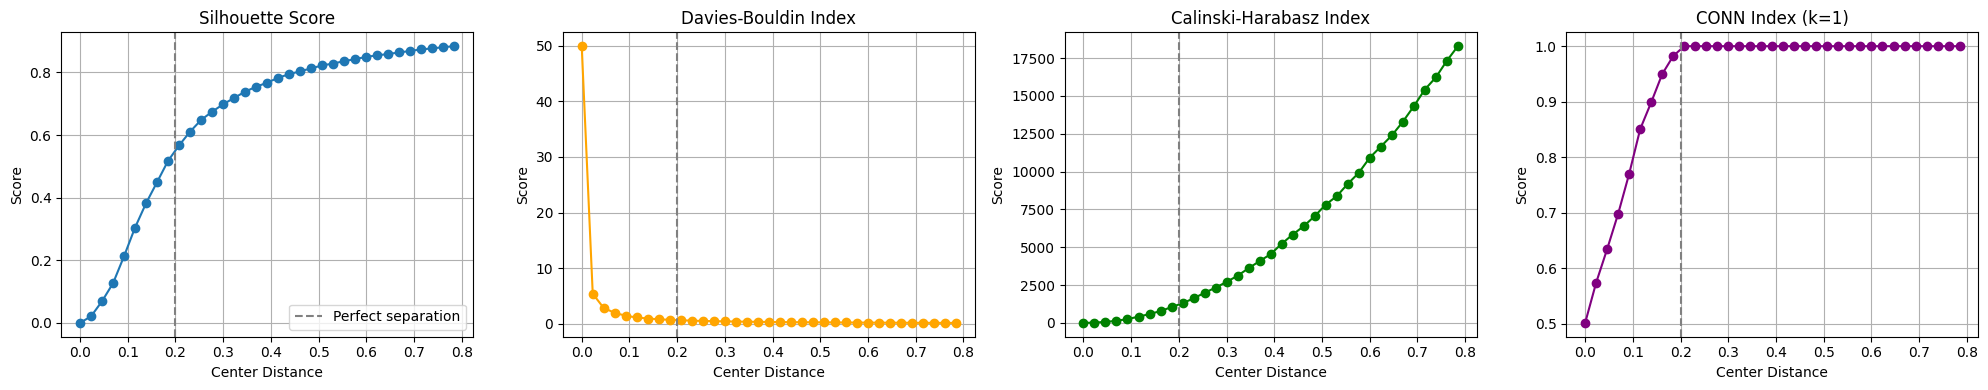

Plotting representative circle examples...


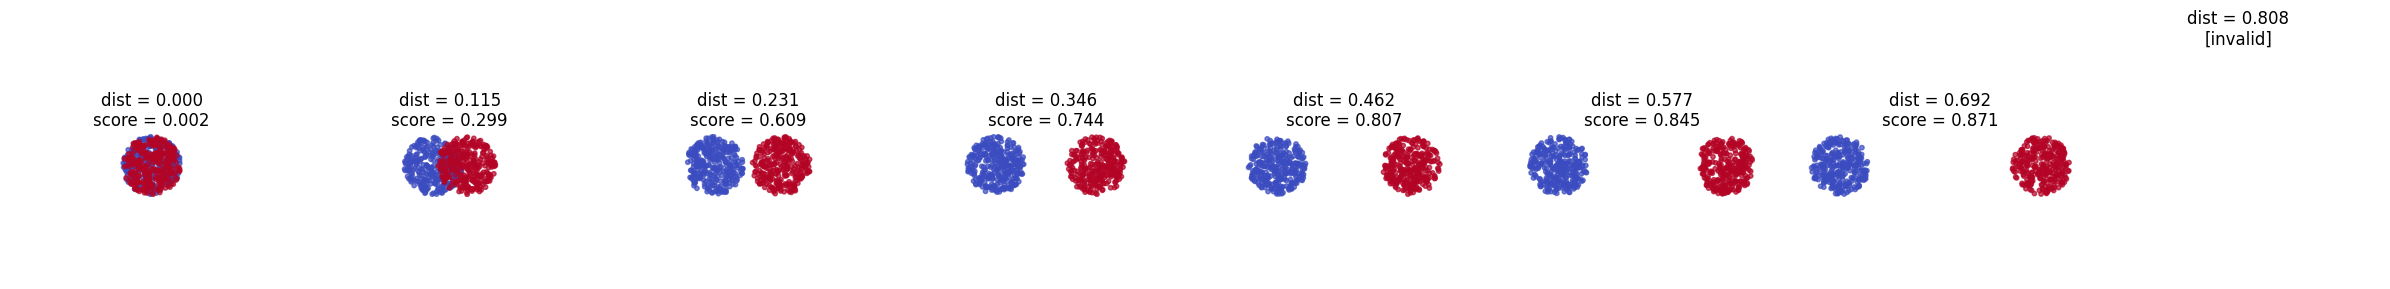

In [44]:
distance_range = np.linspace(0.0, 0.9, 40)
radius = 0.1

analyze_circle_separation_sweep(
    generate_circle_dataset=generate_circle_dataset,
    radius=radius,
    distance_range=distance_range,
    n_samples_per_class=300,
    n_seeds=10,
    plot_every_n=5,
    random_state=42
)


In [35]:
import numpy as np

def generate_bar_dataset(
    bar_width,
    bar_height,
    separation,
    orientation="vertical",  # "vertical" or "horizontal"
    n_samples_1=500,
    n_samples_2=500,
    random_state=None
):
    """
    Generate two rectangular bars uniformly filled, separated by a given distance.

    Parameters:
    - bar_width: float
        Width of each bar (x-axis if vertical, y-axis if horizontal).
    - bar_height: float
        Height of each bar (y-axis if vertical, x-axis if horizontal).
    - separation: float
        Distance between the centers of the two bars (along separation axis).
    - orientation: str
        "vertical" (bars left/right of center) or "horizontal" (bars above/below center).
    - n_samples_1, n_samples_2: int
        Number of points in each bar.
    - random_state: int or None
        Seed for reproducibility.

    Returns:
    - X: np.ndarray of shape (n_samples_1 + n_samples_2, 2)
    - y: np.ndarray of shape (n_samples_1 + n_samples_2,)
    """
    assert orientation in {"vertical", "horizontal"}, "Orientation must be 'vertical' or 'horizontal'"
    assert bar_width > 0 and bar_height > 0, "Bar dimensions must be positive"
    
    rng = np.random.default_rng(random_state)
    cx, cy = 0.5, 0.5

    if orientation == "vertical":
        # Horizontal separation
        cx1 = cx - separation / 2
        cx2 = cx + separation / 2
        cy1 = cy2 = cy

        # Check bounds
        if not (0 <= cx1 - bar_width / 2 and cx2 + bar_width / 2 <= 1.0):
            raise ValueError("Bars extend beyond horizontal bounds.")
        if not (0 <= cy - bar_height / 2 and cy + bar_height / 2 <= 1.0):
            raise ValueError("Bars extend beyond vertical bounds.")

        def sample_bar(n, center_x):
            x = rng.uniform(center_x - bar_width / 2, center_x + bar_width / 2, n)
            y = rng.uniform(cy - bar_height / 2, cy + bar_height / 2, n)
            return np.stack((x, y), axis=1)

    else:  # horizontal
        # Vertical separation
        cy1 = cy - separation / 2
        cy2 = cy + separation / 2
        cx1 = cx2 = cx

        # Check bounds
        if not (0 <= cy1 - bar_width / 2 and cy2 + bar_width / 2 <= 1.0):
            raise ValueError("Bars extend beyond vertical bounds.")
        if not (0 <= cx - bar_height / 2 and cx + bar_height / 2 <= 1.0):
            raise ValueError("Bars extend beyond horizontal bounds.")

        def sample_bar(n, center_y):
            x = rng.uniform(cx - bar_height / 2, cx + bar_height / 2, n)
            y = rng.uniform(center_y - bar_width / 2, center_y + bar_width / 2, n)
            return np.stack((x, y), axis=1)

    # Generate both bars
    X1 = sample_bar(n_samples_1, cx1 if orientation == "vertical" else cy1)
    X2 = sample_bar(n_samples_2, cx2 if orientation == "vertical" else cy2)

    y1 = np.zeros(n_samples_1, dtype=int)
    y2 = np.ones(n_samples_2, dtype=int)

    X = np.vstack((X1, X2))
    y = np.concatenate((y1, y2))
    return X, y


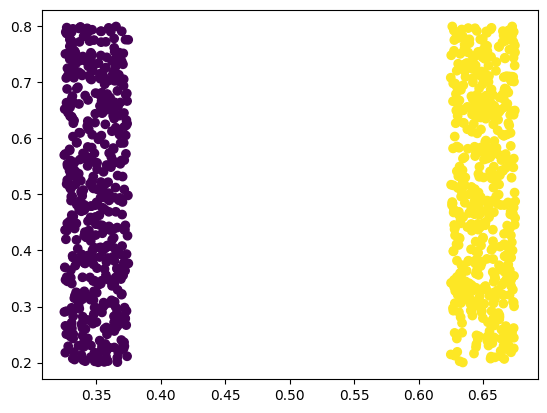

In [36]:
X, y = generate_bar_dataset(
    bar_width=0.05,
    bar_height=0.6,
    separation=0.3,
    orientation="vertical",  # try "horizontal" too!
    n_samples_1=500,
    n_samples_2=500,
    random_state=42
)
plt.figure()
plt.scatter(X[:,0], X[:, 1], c=y)

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from tqdm import tqdm

def analyze_bar_separation_sweep(
    generate_bar_dataset,
    bar_width,
    bar_height,
    separation_range,
    orientation="vertical",  # or "horizontal"
    n_samples_per_class=300,
    n_seeds=10,
    plot_every_n=5,
    random_state=None,
    figsize_per_plot=(3, 3),
    conn_k=1
):
    rng = np.random.default_rng(random_state)
    distances = []
    sil_scores = []
    db_scores = []
    ch_scores = []
    conn_scores = []

    print("Sweeping clustering metrics...")
    for sep in tqdm(separation_range):
        if sep / 2 + (bar_width / 2 if orientation == "vertical" else bar_height / 2) > 0.5:
            continue

        sil_vals, db_vals, ch_vals, conn_vals = [], [], [], []

        for _ in range(n_seeds):
            try:
                X, y = generate_bar_dataset(
                    bar_width=bar_width,
                    bar_height=bar_height,
                    separation=sep,
                    orientation=orientation,
                    n_samples_1=n_samples_per_class,
                    n_samples_2=n_samples_per_class,
                    random_state=rng.integers(0, 1_000_000)
                )
                sil_vals.append(silhouette_score(X, y))
                db_vals.append(davies_bouldin_score(X, y))
                ch_vals.append(calinski_harabasz_score(X, y))
                conn_vals.append(conn_index_score(X, y, n_neighbors=conn_k))
            except ValueError:
                continue

        if sil_vals:
            distances.append(sep)
            sil_scores.append(np.mean(sil_vals))
            db_scores.append(np.mean(db_vals))
            ch_scores.append(np.mean(ch_vals))
            conn_scores.append(np.mean(conn_vals))

    distances = np.array(distances)
    sil_scores = np.array(sil_scores)
    db_scores = np.array(db_scores)
    ch_scores = np.array(ch_scores)
    conn_scores = np.array(conn_scores)

    # === Plot all 4 metrics ===
    perfect_sep = bar_width
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))

    axs[0].plot(distances, sil_scores, marker='o')
    axs[0].axvline(perfect_sep, color='gray', linestyle='--', label='Perfect separation')
    axs[0].set_title("Silhouette Score")
    axs[0].set_xlabel("Bar Separation")
    axs[0].set_ylabel("Score")
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(distances, db_scores, marker='o', color='orange')
    axs[1].axvline(perfect_sep, color='gray', linestyle='--')
    axs[1].set_title("Davies-Bouldin Index")
    axs[1].set_xlabel("Bar Separation")
    axs[1].set_ylabel("Score")
    axs[1].grid(True)

    axs[2].plot(distances, ch_scores, marker='o', color='green')
    axs[2].axvline(perfect_sep, color='gray', linestyle='--')
    axs[2].set_title("Calinski-Harabasz Index")
    axs[2].set_xlabel("Bar Separation")
    axs[2].set_ylabel("Score")
    axs[2].grid(True)

    axs[3].plot(distances, conn_scores, marker='o', color='purple')
    axs[3].axvline(perfect_sep, color='gray', linestyle='--')
    axs[3].set_title(f"CONN Index (k={conn_k})")
    axs[3].set_xlabel("Bar Separation")
    axs[3].set_ylabel("Score")
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()

    # === Plot representative bar examples ===
    print("Plotting representative bar examples...")
    selected_seps = separation_range[::plot_every_n]
    num_plots = len(selected_seps)
    fig, axes = plt.subplots(
        1, num_plots,
        figsize=(figsize_per_plot[0] * num_plots, figsize_per_plot[1]),
        sharex=True, sharey=True
    )
    if num_plots == 1:
        axes = [axes]

    for ax, sep in zip(axes, selected_seps):
        if sep / 2 + (bar_width / 2 if orientation == "vertical" else bar_height / 2) > 0.5:
            ax.set_title(f"sep = {sep:.3f}\n[invalid]")
            ax.axis('off')
            continue

        success = False
        attempts = 0
        while not success and attempts < 10:
            try:
                X, y = generate_bar_dataset(
                    bar_width=bar_width,
                    bar_height=bar_height,
                    separation=sep,
                    orientation=orientation,
                    n_samples_1=n_samples_per_class,
                    n_samples_2=n_samples_per_class,
                    random_state=rng.integers(0, 1_000_000)
                )
                score = silhouette_score(X, y)
                success = True
            except ValueError:
                attempts += 1

        if success:
            ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=10, alpha=0.7)
            ax.set_title(f"sep = {sep:.3f}\nscore = {score:.3f}")
            ax.set_aspect('equal')
            ax.axis('off')
        else:
            ax.set_title(f"sep = {sep:.3f}\n[failed]")
            ax.axis('off')

    plt.tight_layout()
    plt.show()


Sweeping clustering metrics...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.24it/s]


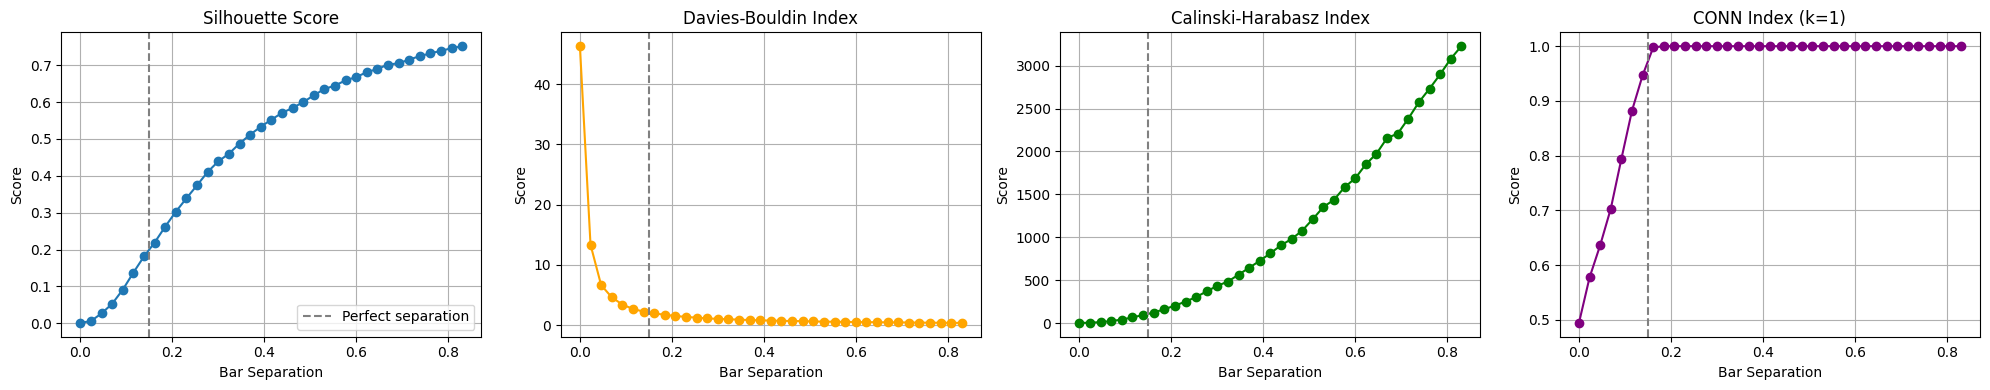

Plotting representative bar examples...


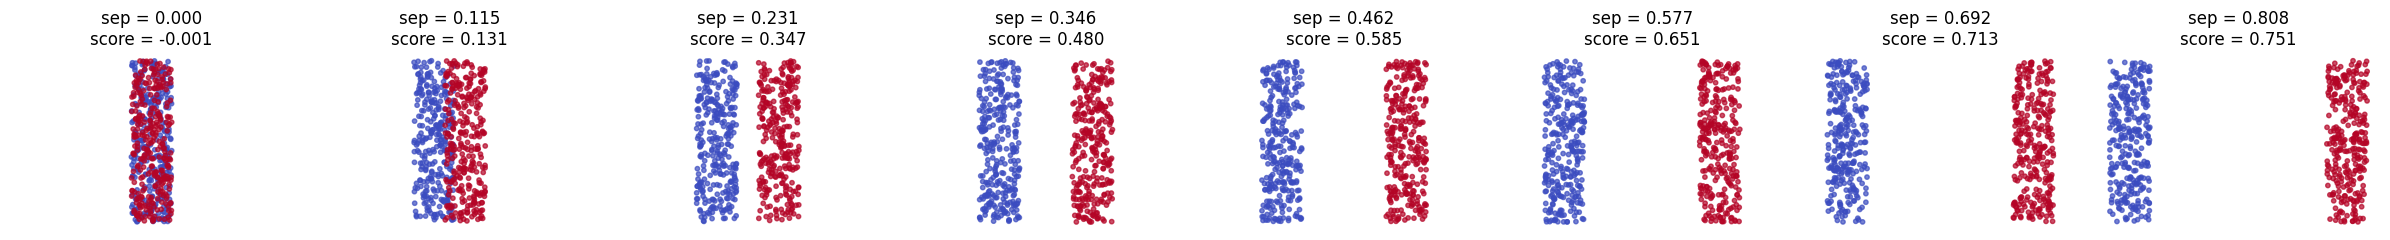

In [46]:
separation_range = np.linspace(0.0, 0.9, 40)
bar_width = 0.15
bar_height = 0.6

analyze_bar_separation_sweep(
    generate_bar_dataset=generate_bar_dataset,
    bar_width=bar_width,
    bar_height=bar_height,
    separation_range=separation_range,
    orientation="vertical",  # or "horizontal"
    n_samples_per_class=300,
    n_seeds=10,
    plot_every_n=5,
    random_state=42
)
